In [31]:
import abc

import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import patches
from torchvision import transforms
from tqdm import tqdm
import torch
from torch import nn, Tensor
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from dataset.FastPatchExtractor import FastPatchExtractor, FastImageLoader
from operators.kernels import gaussian_kernel_generator

In [32]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cpu


In [33]:
patch_size = 6

In [34]:
# This code belongs to the paper
#
# F. Altekrüger, A. Denker, P. Hagemann, J. Hertrich, P. Maass and G. Steidl (2023).
# PatchNR: Learning from Very Few Images by Patch Normalizing Flow Regularization.
# Inverse Problems, vol. 39, no. 6.

def create_NF(num_layers = 5, sub_net_size = 512, dimension=patch_size**2):
    """
    Creates the patchNR network
    """
    def subnet_fc(c_in, c_out):
        return nn.Sequential(nn.Linear(c_in, sub_net_size), nn.ReLU(),
                             nn.Linear(sub_net_size, sub_net_size), nn.ReLU(),
                             nn.Linear(sub_net_size,  c_out))
    nodes = [Ff.InputNode(dimension, name='input')]
    for k in range(num_layers):
        nodes.append(Ff.Node(nodes[-1],
                          Fm.GLOWCouplingBlock,
                          {'subnet_constructor':subnet_fc, 'clamp':1.6},
                          name=F'coupling_{k}'))
        nodes.append(Ff.Node(nodes[-1],
                          Fm.PermuteRandom,
                          {'seed':(k+1)},
                          name=F'permute_flow_{k}'))
    nodes.append(Ff.OutputNode(nodes[-1], name='output'))

    return Ff.ReversibleGraphNet(nodes, verbose=False).to(DEVICE)

In [35]:
class Operator:
    @abc.abstractmethod
    def __call__(self, *args, **kwargs):
        raise NotImplementedError('Operator has to be callable')

In [36]:
class BlurOperator:
    def __init__(self, kernel, device='cpu'):
        self.device = device
        self.kernel = kernel
        self.kernel_size = kernel.squeeze().size(0)

    def __call__(self, image, padding=True):
        if padding:
            pad_trans = transforms.Pad([self.kernel_size // 2, ], padding_mode="reflect")
            image = pad_trans(image)
        return F.conv2d(image, self.kernel).to(self.device)

In [37]:
class Regulariser:
    @abc.abstractmethod
    def evaluate(self, input: Tensor):
        raise NotImplementedError('Evaluate not implemented')

    @abc.abstractmethod
    def get_hparams(self):
        raise NotImplementedError('Regulariser should return the hyperparameters with this function')


In [69]:
class PatchNrRegulariser(Regulariser):

    def __init__(self, flow_model, p_size=6, sample_number=40000, padding=True, padding_size=8):
        self.padding = padding
        self.padding_size = padding_size
        self.sample_number = sample_number
        self.flow_model = flow_model
        self.patch_size = patch_size
        self.patch_extractor = FastPatchExtractor(p_dim=p_size)
        self.pad_transformation = transforms.Pad([self.padding_size, ], padding_mode="reflect")

    def loss(self, batch):
        z, z_log_det = self.flow_model(batch, rev=True)
        return torch.mean(torch.sum(z**2, dim=1)/2) - torch.mean(z_log_det)

    def get_hparams(self):
        return {
            "p_size": self.patch_size,
            "sample_number": self.sample_number,
            "padding_size": self.padding_size,
            "padding": self.padding
        }

    def evaluate(self, img):
        padded_img = self.pad_transformation(img) if self.padding else img
        batch = self.patch_extractor.extract(padded_img, self.sample_number)
        return self.loss(batch)

In [79]:
def variational_model_solver(deg_img: Tensor, operator: Operator, regulariser: Regulariser, lam=0.87, steps = 600, device=DEVICE):
    degraded_image = deg_img.to(device)
    reconstructed_image = torch.tensor(degraded_image.clone(), dtype=torch.float, device=device, requires_grad=True)

    optimizer = torch.optim.Adam([reconstructed_image], lr=0.005)

    step_bar = tqdm(range(steps))

    losses = []
    likelihoods = []
    regularisation = []

    for _ in step_bar:
        optimizer.zero_grad()
        reg = regulariser.evaluate(reconstructed_image)
        likelihood = torch.sum((operator(reconstructed_image) - degraded_image)**2)
        loss = likelihood + lam*reg
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        likelihoods.append(likelihood.item())
        regularisation.append(reg)
        step_bar.set_description_str(f'Loss: {loss}; Likelihood: {likelihood} R: {reg}')
    return reconstructed_image, (losses, likelihoods, regularisation)

In [80]:
def plot_image(path, img0, selected_patch=(100, 100), p_size=30):
    image0 = img0.to('cpu')
  #  image1 = img1.to('cpu')
    out_dim = (p_size, p_size)
    patch_extractor = FastPatchExtractor(p_dim=p_size, pad=True)
    c, x, y = image0.size()
    p_x, p_y = selected_patch
    p_pos = p_y*x + p_x
    p_image0 = torch.reshape(patch_extractor.extract(image0.unsqueeze(0))[p_pos], out_dim)
    fig, axes = plt.subplots(2, 1, figsize=(3,4))
    rect1 = patches.Rectangle((p_x, p_y), p_size, p_size, linewidth=1, edgecolor='r',facecolor='none')
    axes[0].imshow(image0.squeeze(), cmap='gray')
    axes[0].add_patch(rect1)
    axes[0].axis('off')
    axes[1].imshow(p_image0.squeeze(), cmap='gray')
    axes[1].axis('off')
    fig.tight_layout()
    fig.show()
    fig.savefig(path)

In [81]:
model_weights = torch.load('patchNR/patchNR_weights/weights_material.pth', map_location=DEVICE)
model = create_NF()
model.load_state_dict(model_weights['net_state_dict'])

<All keys matched successfully>

In [82]:
patch_nr_regulariser = PatchNrRegulariser(model, p_size=patch_size, sample_number=40000, padding=True, padding_size=8)

In [83]:
gaussian_kernel = gaussian_kernel_generator(7, 6)
blur_operator = BlurOperator(gaussian_kernel, device=DEVICE)

In [84]:
#plot parameters
plot_sel_patch_pos = (325, 325)
plot_patch_size = 50

/tmp/ipykernel_5125/414492940.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


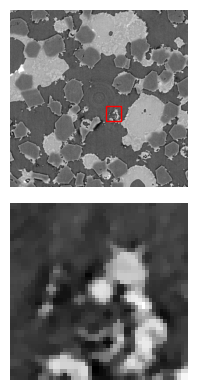

In [85]:
image_loader = FastImageLoader('data/material_pt_nr/test.png')
ground_truth = image_loader[0]
plot_image('results/deblurring/ground_truth.png', ground_truth, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

/tmp/ipykernel_5125/414492940.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


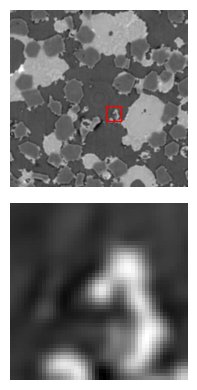

In [86]:
degraded_image = blur_operator(ground_truth)
plot_image('results/deblurring/ground_truth.png', degraded_image, selected_patch=plot_sel_patch_pos, p_size=plot_patch_size)

In [87]:
reconstructed = variational_model_solver(degraded_image, blur_operator, regulariser=patch_nr_regulariser)

/tmp/ipykernel_5125/3268187038.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstructed_image = torch.tensor(degraded_image.clone(), dtype=torch.float, device=device, requires_grad=True)
Loss: 244501648.0; Likelihood: 5774934.0 R: 274398528.0:   3%|▎         | 17/600 [01:23<47:40,  4.91s/it]  


KeyboardInterrupt: 